In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# 替换为您Google Drive中'Med-VQA'文件夹的实际路径
med_vqa_folder_path = '/content/drive/MyDrive/Med-VQA'

# 检查文件夹是否存在
if os.path.exists(med_vqa_folder_path):
    print(f"列出 '{med_vqa_folder_path}' 中的文件和文件夹：")
    for item in os.listdir(med_vqa_folder_path):
        print(item)
else:
    print(f"错误：文件夹 '{med_vqa_folder_path}' 不存在。请检查路径或确保文件夹已上传到您的Google Drive。")


列出 '/content/drive/MyDrive/Med-VQA' 中的文件和文件夹：
vqa_rad_test_4maincatAndOther.csv
vqa_rad_train.csv
vqa_rad.csv
vqa_rad_test.csv
vqa_rad_train_4maincatAndOther.csv
vqa_rad_valid.csv
vqa_rad_only4maincat.csv
VQA_RAD Image Folder


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
csv_file_path = '/content/drive/MyDrive/Med-VQA/vqa_rad.csv'
df = pd.read_csv(csv_file_path)

print(f"Dataset loaded successfully from: {csv_file_path}")
print("First 5 rows of the DataFrame:")
print(df.head())
print("\nDataFrame Info:")
df.info()

Dataset loaded successfully from: /content/drive/MyDrive/Med-VQA/vqa_rad.csv
First 5 rows of the DataFrame:
        img_id                                      question      answer  \
0  synpic54610            are regions of the brain infarcted         yes   
1  synpic29265                are the lungs normal appearing          no   
2  synpic29265           is there evidence of a pneumothorax          no   
3  synpic28602  what type of imaging does this not represent  ultrasound   
4  synpic29265                    is this a mri of the chest          no   

      category   mode  
0         pres  train  
1  abnormality  train  
2         pres  train  
3     modality  train  
4     modality  train  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_id    2248 non-null   object
 1   question  2248 non-null   object
 2   answer    2

In [ ]:
df['question_length'] = df['question'].apply(lambda x: len(str(x).split()))

def get_answer_type(answer):
    closed_ended_keywords = ['yes', 'no', 'present', 'absent', 'normal', 'abnormal', 'true', 'false']
    ans_lower = str(answer).lower().strip()

    # Check if the answer is a number
    if ans_lower.replace('.', '', 1).isdigit(): # Allows for decimals
        return 'closed_ended'

    # Check if the answer is a single word and in closed_ended_keywords
    if len(ans_lower.split()) == 1 and ans_lower in closed_ended_keywords:
        return 'closed_ended'

    return 'open_ended'

df['answer_type'] = df['answer'].apply(get_answer_type)

print("Extracted question lengths and determined answer types.")
print("First 5 rows with new columns:")
print(df[['question', 'question_length', 'answer', 'answer_type']].head())

Extracted question lengths and determined answer types.
First 5 rows with new columns:
                                       question  question_length      answer  \
0            are regions of the brain infarcted                6         yes   
1                are the lungs normal appearing                5          no   
2           is there evidence of a pneumothorax                6          no   
3  what type of imaging does this not represent                8  ultrasound   
4                    is this a mri of the chest                7          no   

    answer_type  
0  closed_ended  
1  closed_ended  
2  closed_ended  
3    open_ended  
4  closed_ended  


/tmp/ipython-input-3443009972.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='answer_type', data=df, palette='viridis')


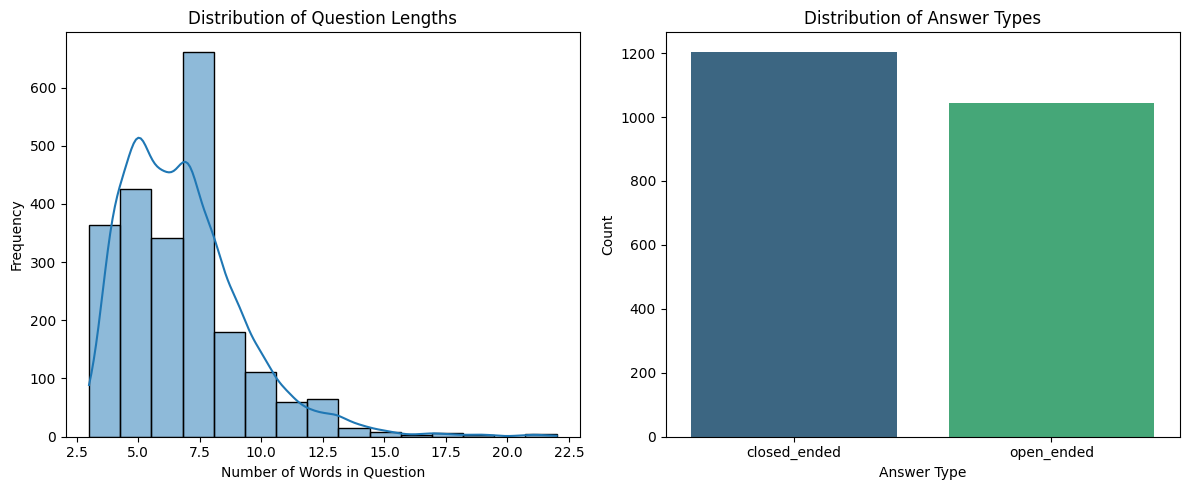

Visualized distributions of question lengths and answer types.


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['question_length'], bins=15, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.countplot(x='answer_type', data=df, palette='viridis')
plt.title('Distribution of Answer Types')
plt.xlabel('Answer Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("Visualized distributions of question lengths and answer types.")

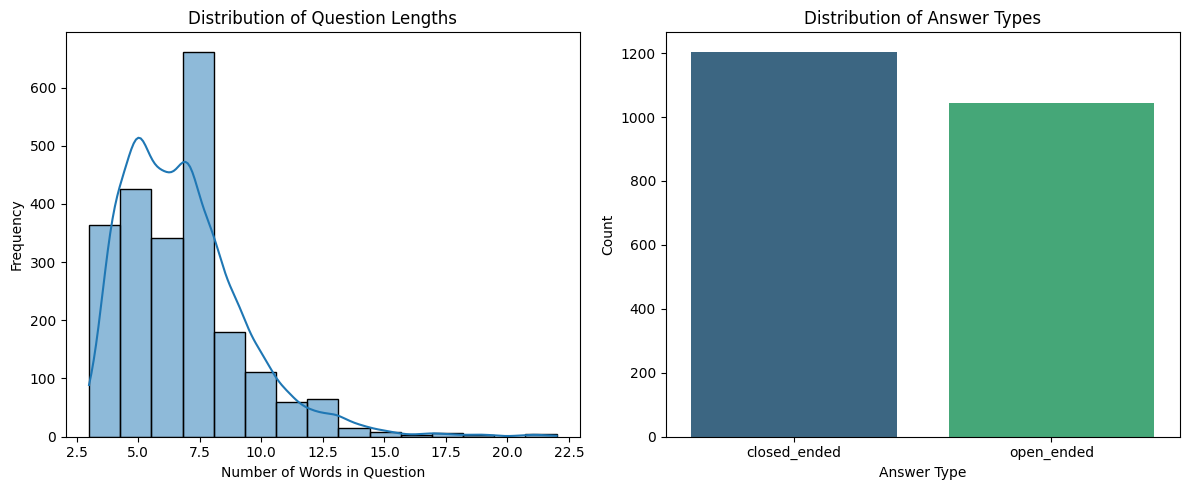

Visualized distributions of question lengths and answer types.


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['question_length'], bins=15, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.countplot(x='answer_type', data=df, hue='answer_type', palette='viridis', legend=False)
plt.title('Distribution of Answer Types')
plt.xlabel('Answer Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("Visualized distributions of question lengths and answer types.")

In [ ]:
import re

def tokenize_text(text):
    text = str(text).lower() # Convert to string and lowercase
    tokens = re.findall(r"\b\w+\b", text) # Simple tokenization: extract words
    return tokens

df['question_tokens'] = df['question'].apply(tokenize_text)
df['answer_tokens'] = df['answer'].apply(tokenize_text)

# Build vocabulary
vocabulary = set()
for tokens in df['question_tokens']:
    vocabulary.update(tokens)
for tokens in df['answer_tokens']:
    vocabulary.update(tokens)

# Add special tokens for padding and unknown words
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
vocabulary.add(PAD_TOKEN)
vocabulary.add(UNK_TOKEN)

# Create word to index and index to word mappings
word_to_idx = {word: i for i, word in enumerate(sorted(list(vocabulary)))}
idx_to_word = {i: word for word, i in word_to_idx.items()}

# Numericalize questions and answers
df['question_numerical'] = df['question_tokens'].apply(lambda tokens: [word_to_idx.get(word, word_to_idx[UNK_TOKEN]) for word in tokens])
df['answer_numerical'] = df['answer_tokens'].apply(lambda tokens: [word_to_idx.get(word, word_to_idx[UNK_TOKEN]) for word in tokens])

print(f"Total vocabulary size: {len(vocabulary)}")
print("First 5 rows with tokenized and numericalized data:")
print(df[['question', 'question_tokens', 'question_numerical', 'answer', 'answer_tokens', 'answer_numerical']].head())
print(f"\nSample word_to_idx (first 10 items): {list(word_to_idx.items())[:10]}")
print(f"Sample idx_to_word (first 10 items): {list(idx_to_word.items())[:10]}")

Total vocabulary size: 1416
First 5 rows with tokenized and numericalized data:
                                       question  \
0            are regions of the brain infarcted   
1                are the lungs normal appearing   
2           is there evidence of a pneumothorax   
3  what type of imaging does this not represent   
4                    is this a mri of the chest   

                                     question_tokens  \
0          [are, regions, of, the, brain, infarcted]   
1               [are, the, lungs, normal, appearing]   
2         [is, there, evidence, of, a, pneumothorax]   
3  [what, type, of, imaging, does, this, not, rep...   
4                 [is, this, a, mri, of, the, chest]   

                             question_numerical      answer answer_tokens  \
0              [113, 1083, 928, 1272, 188, 674]         yes         [yes]   
1                    [113, 1272, 804, 908, 102]          no          [no]   
2               [721, 1276, 471, 928, 23, 101

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("Dataset split into training, validation, and test sets successfully.")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
category_counts = df['category'].value_counts()
rare_categories = category_counts[category_counts < 2].index

# Create a new column for stratification, replacing rare categories with 'Other'
df_stratify = df.copy()
df_stratify['category_for_split'] = df_stratify['category'].replace(rare_categories, 'Other')

# Perform the first split (70% train, 30% temp)
train_df, temp_df = train_test_split(df_stratify, test_size=0.3, random_state=42, stratify=df_stratify['category_for_split'])

# Perform the second split (50% val, 50% test from temp_df, resulting in 15% val, 15% test)
# To maintain stratification consistency, we need to stratify by the original 'category' in temp_df
# However, since temp_df might still contain rare categories from the original df
# and train_test_split requires at least 2 samples per class for stratification,
# we will re-evaluate stratification for the second split.

# Re-check category counts in temp_df for the second stratification
temp_category_counts = temp_df['category_for_split'].value_counts()
temp_rare_categories = temp_category_counts[temp_category_counts < 2].index
temp_df_stratify = temp_df.copy()
temp_df_stratify['category_for_split_temp'] = temp_df_stratify['category_for_split'].replace(temp_rare_categories, 'Other_temp_split')

val_df, test_df = train_test_split(temp_df_stratify, test_size=0.5, random_state=42, stratify=temp_df_stratify['category_for_split_temp'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("Dataset split into training, validation, and test sets successfully, handling rare categories for stratification.")

Training set size: 1573
Validation set size: 337
Test set size: 338
Dataset split into training, validation, and test sets successfully, handling rare categories for stratification.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

print("Libraries for VQA model definition imported successfully.")

Libraries for VQA model definition imported successfully.


In [ ]:
class VQA_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_size=512, num_answers=None):
        super(VQA_Model, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        # 1a. Image Encoder (Pre-trained ResNet)
        # Load a pre-trained ResNet-50 model
        resnet = models.resnet50(pretrained=True)
        # Remove the last fully connected layer (classifier)
        modules = list(resnet.children())[:-1]
        self.image_encoder = nn.Sequential(*modules)

        # Freeze parameters of the pre-trained CNN
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Adjust output feature size of ResNet if necessary (e.g., from 2048 to 1024/512)
        # ResNet50 global average pooling outputs 2048 features
        self.image_feature_dim = resnet.fc.in_features # This will be 2048 for ResNet50

        # 1b. Text Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_idx[PAD_TOKEN])

        # 1c. Question Encoder (LSTM)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

        # 1d. Fusion Layer
        # We'll concatenate image features (2048) and LSTM output (hidden_size=512)
        # Total concatenated feature size will be image_feature_dim + hidden_size
        self.fusion = nn.Sequential(
            nn.Linear(self.image_feature_dim + hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # 1e. Classifier Layer
        # Output should be vocab_size to predict any word in the vocabulary as an answer
        self.classifier = nn.Linear(hidden_size // 2, vocab_size)

    def forward(self, images, questions):
        # Image Features
        image_features = self.image_encoder(images)
        # Flatten the features (e.g., from (batch_size, 2048, 1, 1) to (batch_size, 2048))
        image_features = image_features.view(image_features.size(0), -1)

        # Question Features
        embedded_questions = self.embedding(questions)
        lstm_out, (hidden, cell) = self.lstm(embedded_questions)
        # Use the last hidden state of the LSTM as the question feature
        question_features = hidden.squeeze(0) # hidden shape: (num_layers * num_directions, batch, hidden_size)

        # Fusion
        fused_features = torch.cat((image_features, question_features), dim=1)
        fused_features = self.fusion(fused_features)

        # Classifier
        predictions = self.classifier(fused_features)

        return predictions

# Get vocabulary size from the previously built word_to_idx
vocab_size = len(word_to_idx)

# Instantiate the model
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQA_Model(vocab_size).to(device)

print(f"VQA Model instantiated successfully on device: {device}")
print(model)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx[PAD_TOKEN]) # Ignore padding token in loss calculation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) defined successfully.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 63.2MB/s]


VQA Model instantiated successfully on device: cuda
VQA_Model(
  (image_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


In [ ]:
class VQA_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_size=512, num_answers=None):
        super(VQA_Model, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        # 1a. Image Encoder (Pre-trained ResNet)
        # Load a pre-trained ResNet-50 model, using recommended 'weights' parameter
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Remove the last fully connected layer (classifier)
        modules = list(resnet.children())[:-1]
        self.image_encoder = nn.Sequential(*modules)

        # Freeze parameters of the pre-trained CNN
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Adjust output feature size of ResNet if necessary (e.g., from 2048 to 1024/512)
        # ResNet50 global average pooling outputs 2048 features
        self.image_feature_dim = resnet.fc.in_features # This will be 2048 for ResNet50

        # 1b. Text Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_idx[PAD_TOKEN])

        # 1c. Question Encoder (LSTM)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)

        # 1d. Fusion Layer
        # We'll concatenate image features (2048) and LSTM output (hidden_size=512)
        # Total concatenated feature size will be image_feature_dim + hidden_size
        self.fusion = nn.Sequential(
            nn.Linear(self.image_feature_dim + hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # 1e. Classifier Layer
        # Output should be vocab_size to predict any word in the vocabulary as an answer
        self.classifier = nn.Linear(hidden_size // 2, vocab_size)

    def forward(self, images, questions):
        # Image Features
        image_features = self.image_encoder(images)
        # Flatten the features (e.g., from (batch_size, 2048, 1, 1) to (batch_size, 2048))
        image_features = image_features.view(image_features.size(0), -1)

        # Question Features
        embedded_questions = self.embedding(questions)
        lstm_out, (hidden, cell) = self.lstm(embedded_questions)
        # Use the last hidden state of the LSTM as the question feature
        question_features = hidden.squeeze(0) # hidden shape: (num_layers * num_directions, batch, hidden_size)

        # Fusion
        fused_features = torch.cat((image_features, question_features), dim=1)
        fused_features = self.fusion(fused_features)

        # Classifier
        predictions = self.classifier(fused_features)

        return predictions

# Get vocabulary size from the previously built word_to_idx
vocab_size = len(word_to_idx)

# Instantiate the model
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQA_Model(vocab_size).to(device)

print(f"VQA Model instantiated successfully on device: {device}")
print(model)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx[PAD_TOKEN]) # Ignore padding token in loss calculation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) defined successfully.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


VQA Model instantiated successfully on device: cuda
VQA_Model(
  (image_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)


In [ ]:
import torchvision.transforms as transforms

# Define image transformations for pre-trained ResNet
# ResNet models typically expect 224x224 input and normalization with specific mean/std
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Image transformations defined successfully.")

Image transformations defined successfully.


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Determine maximum question length for padding
max_question_len = df['question_numerical'].apply(len).max()

# Determine maximum answer length for padding
# Since the model predicts a single token answer, padding answers is less critical for prediction but useful for consistency
# However, the current model architecture is designed to predict a single word, so we need to ensure the target label is a single index.
# Let's consider the task. The current classifier outputs vocab_size, implying a single word prediction.
# For multi-word answers, this approach would need modification.
# For now, let's assume single-word answers as target or predict the first token of the answer.
# If answers can be multiple words, a different loss/prediction mechanism (e.g., sequence generation) would be needed.
# For this baseline, we will simplify: if an answer is multi-word, we will take its first token as the target.
# This means max_answer_len conceptually becomes 1 for classification purposes, but we can still pad for consistency if needed.
max_answer_len = df['answer_numerical'].apply(len).max() # Keep this to show potential multi-word answers, but for training, we'll pick one.


class VQADataset(Dataset):
    def __init__(self, dataframe, image_folder_path, transform, word_to_idx, max_question_len, max_answer_len):
        self.dataframe = dataframe
        self.image_folder_path = image_folder_path
        self.transform = transform
        self.word_to_idx = word_to_idx
        self.max_question_len = max_question_len
        self.max_answer_len = max_answer_len
        self.pad_idx = word_to_idx[PAD_TOKEN]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load image
        img_name = row['img_id'] + '.jpg' # Assuming image files are .jpg
        img_path = os.path.join(self.image_folder_path, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Numericalize and pad question
        question_numerical = row['question_numerical']
        # Pad questions to max_question_len
        padded_question = question_numerical + [self.pad_idx] * (self.max_question_len - len(question_numerical))
        padded_question = torch.tensor(padded_question, dtype=torch.long)

        # Numericalize answer
        answer_numerical = row['answer_numerical']
        # For this baseline, we'll use the first token of the answer as the target label for classification.
        # If the answer is empty or not numericalized properly, use UNK_TOKEN index.
        answer_label = answer_numerical[0] if answer_numerical else self.word_to_idx[UNK_TOKEN]
        answer_label = torch.tensor(answer_label, dtype=torch.long)

        return image, padded_question, answer_label

print(f"Maximum question length: {max_question_len}")
print(f"Maximum answer length (for reference, not directly used as sequence target): {max_answer_len}")
print("VQADataset class defined successfully.")

Maximum question length: 22
Maximum answer length (for reference, not directly used as sequence target): 17
VQADataset class defined successfully.


In [ ]:
def collate_fn(batch):
    # batch is a list of (image, padded_question, answer_label)
    images = torch.stack([item[0] for item in batch])

    # Questions: pad to the max length in the current batch
    questions_numerical = [item[1] for item in batch]
    # Get max length of questions in this batch (since they were already padded to global max)
    # Or, if we hadn't padded them globally, we'd find the max_len here.
    # Given they are already padded to global max_question_len, no further padding is strictly needed,
    # but we can re-pad to the longest in *this batch* if we want to save memory/computation.
    # For simplicity, we assume padded_question from Dataset is already correct length.
    # If we wanted dynamic padding per batch, the Dataset __getitem__ would return unpadded sequence
    # and collate_fn would handle padding based on max_len in the batch.
    # Since the `VQADataset` already pads to `max_question_len`, we can just stack them.
    questions = torch.stack(questions_numerical)

    answers = torch.stack([item[2] for item in batch])

    return images, questions, answers

# Define image folder path (assuming it's in the same directory as the CSV for now, adjust if needed)
image_folder_path = '/content/drive/MyDrive/Med-VQA/VQA_RAD Image Folder'

batch_size = 32

# Instantiate Datasets
train_dataset = VQADataset(train_df, image_folder_path, preprocess, word_to_idx, max_question_len, max_answer_len)
val_dataset = VQADataset(val_df, image_folder_path, preprocess, word_to_idx, max_question_len, max_answer_len)
test_dataset = VQADataset(test_df, image_folder_path, preprocess, word_to_idx, max_question_len, max_answer_len)

# Instantiate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

DataLoaders created with batch size: 32
Number of training batches: 50
Number of validation batches: 11
Number of test batches: 11


In [ ]:
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    for batch_idx, (images, questions, answers) in enumerate(train_loader):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        optimizer.zero_grad()

        outputs = model(images, questions)
        # For single-word answers, outputs should be (batch_size, vocab_size)
        # answers should be (batch_size,)
        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad(): # Disable gradient calculation during validation
        for batch_idx, (images, questions, answers) in enumerate(val_loader):
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)

            outputs = model(images, questions)
            loss = criterion(outputs, answers)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += answers.size(0)
            correct_predictions += (predicted == answers).sum().item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print("Training complete.")

Epoch [1/10], Train Loss: 4.6498, Val Loss: 3.5687, Val Accuracy: 0.3086
Epoch [2/10], Train Loss: 3.6626, Val Loss: 3.2652, Val Accuracy: 0.3294
Epoch [3/10], Train Loss: 3.3208, Val Loss: 3.1909, Val Accuracy: 0.3205
Epoch [4/10], Train Loss: 3.3647, Val Loss: 3.2084, Val Accuracy: 0.3086
Epoch [5/10], Train Loss: 3.2115, Val Loss: 3.0457, Val Accuracy: 0.3412
Epoch [6/10], Train Loss: 2.9759, Val Loss: 3.0397, Val Accuracy: 0.3561
Epoch [7/10], Train Loss: 2.9353, Val Loss: 3.0947, Val Accuracy: 0.3442
Epoch [8/10], Train Loss: 2.7683, Val Loss: 2.8804, Val Accuracy: 0.3591
Epoch [9/10], Train Loss: 2.5934, Val Loss: 2.8425, Val Accuracy: 0.3591
Epoch [10/10], Train Loss: 2.4675, Val Loss: 2.7674, Val Accuracy: 0.4214
Training complete.


In [ ]:
model.eval() # Set model to evaluation mode

test_correct_predictions = 0
test_total_predictions = 0

all_true_answers = []
all_predicted_answers = []
all_answer_types = []

with torch.no_grad(): # Disable gradient calculation
    for batch_idx, (images, questions, answers) in enumerate(test_loader):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        outputs = model(images, questions)

        _, predicted = torch.max(outputs.data, 1)

        test_total_predictions += answers.size(0)
        test_correct_predictions += (predicted == answers).sum().item()

        all_true_answers.extend(answers.cpu().numpy())
        all_predicted_answers.extend(predicted.cpu().numpy())

        # Retrieve corresponding answer types from the original test_df
        # Assuming the order in test_loader matches the order in test_df for now
        # A more robust way would be to pass answer_type through the dataset/dataloader
        start_idx = batch_idx * test_loader.batch_size
        end_idx = min(start_idx + test_loader.batch_size, len(test_df))
        all_answer_types.extend(test_df.iloc[start_idx:end_idx]['answer_type'].tolist())

overall_test_accuracy = test_correct_predictions / test_total_predictions
print(f'Overall Test Accuracy: {overall_test_accuracy:.4f}')

# Analyze performance for closed-ended and open-ended questions
closed_ended_correct = 0
closed_ended_total = 0
open_ended_correct = 0
open_ended_total = 0

for i in range(len(all_true_answers)):
    true_ans = all_true_answers[i]
    pred_ans = all_predicted_answers[i]
    ans_type = all_answer_types[i]

    if ans_type == 'closed_ended':
        closed_ended_total += 1
        if true_ans == pred_ans:
            closed_ended_correct += 1
    else:
        open_ended_total += 1
        if true_ans == pred_ans:
            open_ended_correct += 1

closed_ended_accuracy = closed_ended_correct / closed_ended_total if closed_ended_total > 0 else 0
open_ended_accuracy = open_ended_correct / open_ended_total if open_ended_total > 0 else 0

print(f'Closed-ended Questions Accuracy: {closed_ended_accuracy:.4f} ({closed_ended_correct}/{closed_ended_total})')
print(f'Open-ended Questions Accuracy: {open_ended_accuracy:.4f} ({open_ended_correct}/{open_ended_total})')

print("Model evaluation on test set complete.")

Overall Test Accuracy: 0.3609
Closed-ended Questions Accuracy: 0.6221 (107/172)
Open-ended Questions Accuracy: 0.0904 (15/166)
Model evaluation on test set complete.


/tmp/ipython-input-4288149246.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_types, y=accuracies, palette='coolwarm')


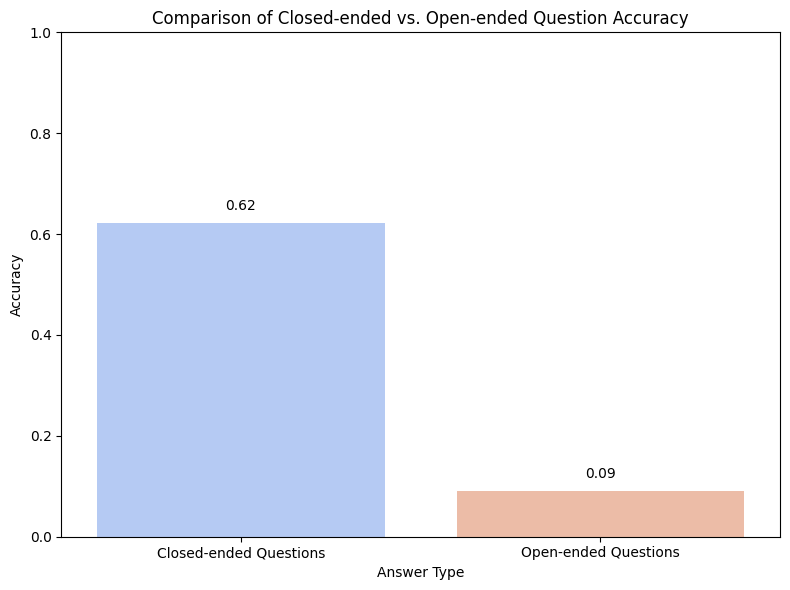

Bar chart comparing closed-ended and open-ended question accuracy displayed.


In [ ]:
accuracy_types = ['Closed-ended Questions', 'Open-ended Questions']
accuracies = [closed_ended_accuracy, open_ended_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=accuracy_types, y=accuracies, palette='coolwarm')

plt.title('Comparison of Closed-ended vs. Open-ended Question Accuracy')
plt.xlabel('Answer Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0) # Accuracy ranges from 0 to 1

# Add accuracy values on top of the bars
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Bar chart comparing closed-ended and open-ended question accuracy displayed.")

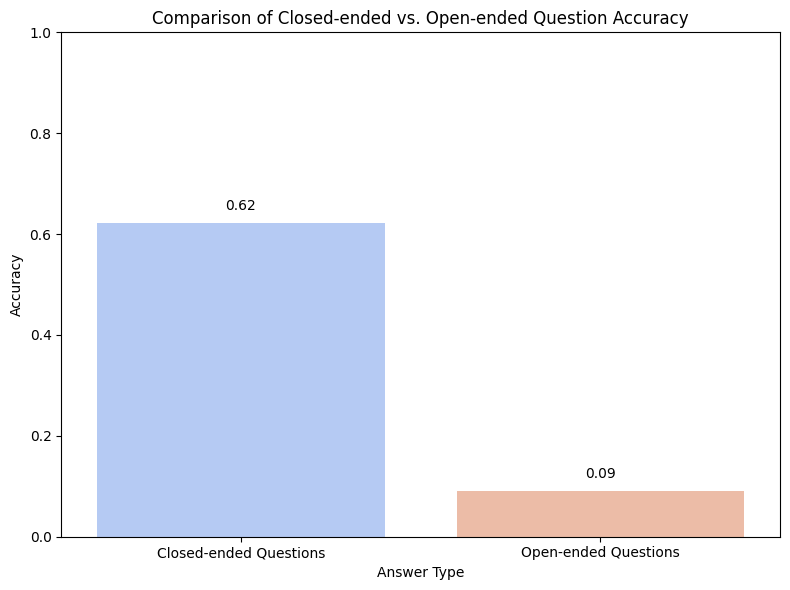

Bar chart comparing closed-ended and open-ended question accuracy displayed.


In [ ]:
accuracy_types = ['Closed-ended Questions', 'Open-ended Questions']
accuracies = [closed_ended_accuracy, open_ended_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=accuracy_types, y=accuracies, hue=accuracy_types, palette='coolwarm', legend=False)

plt.title('Comparison of Closed-ended vs. Open-ended Question Accuracy')
plt.xlabel('Answer Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0) # Accuracy ranges from 0 to 1

# Add accuracy values on top of the bars
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Bar chart comparing closed-ended and open-ended question accuracy displayed.")

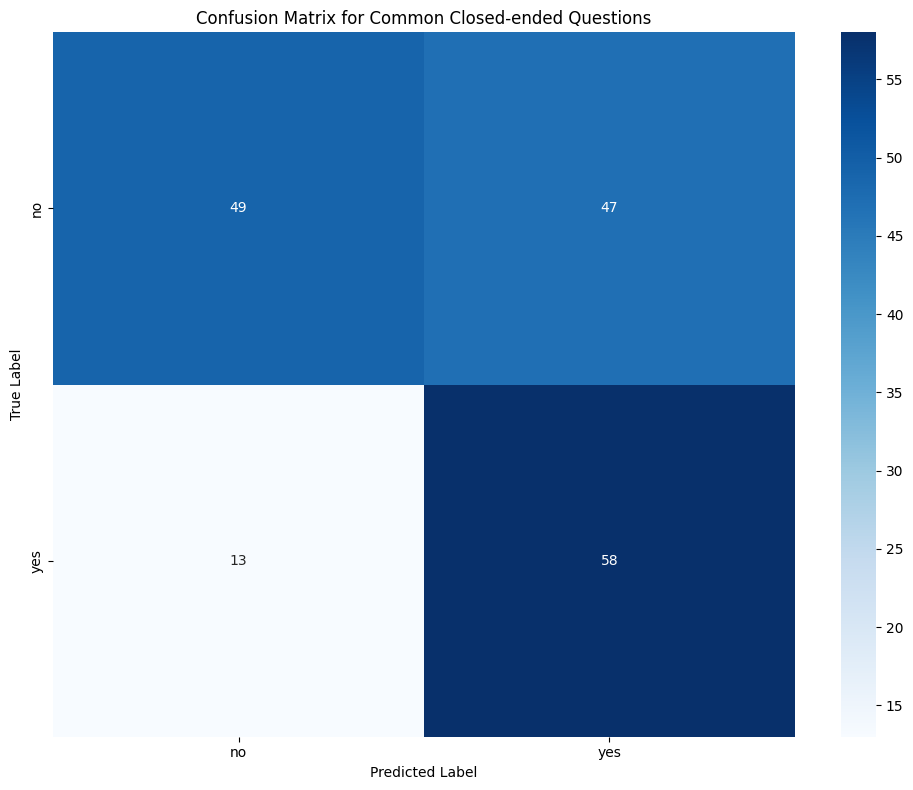

Confusion matrix for common closed-ended questions displayed.


In [ ]:
from sklearn.metrics import confusion_matrix

# 1. Convert numerical predictions and true answers back to word forms
# Filter out potential indices that might be out of bounds if there are any issues, though they shouldn't be.
all_true_answers_words = [idx_to_word[idx] for idx in all_true_answers if idx in idx_to_word]
all_predicted_answers_words = [idx_to_word[idx] for idx in all_predicted_answers if idx in idx_to_word]

# 2. Filter for closed-ended questions
closed_ended_true_answers_words = []
closed_ended_predicted_answers_words = []

for i, ans_type in enumerate(all_answer_types):
    if ans_type == 'closed_ended':
        # Ensure indices are within bounds before appending
        if i < len(all_true_answers_words) and i < len(all_predicted_answers_words):
            closed_ended_true_answers_words.append(all_true_answers_words[i])
            closed_ended_predicted_answers_words.append(all_predicted_answers_words[i])

# 3. Identify common closed-ended answers and filter for them
# A heuristic for common closed-ended answers
common_closed_ended_words = ['yes', 'no', 'normal', 'abnormal', '<unk>', '<pad>'] # Include UNK and PAD as they might appear

filtered_true = []
filtered_predicted = []

for true_ans, pred_ans in zip(closed_ended_true_answers_words, closed_ended_predicted_answers_words):
    if true_ans in common_closed_ended_words and pred_ans in common_closed_ended_words:
        filtered_true.append(true_ans)
        filtered_predicted.append(pred_ans)

# Define the labels for the confusion matrix to ensure consistent ordering
labels = sorted(list(set(filtered_true + filtered_predicted)))

if len(labels) > 1 and len(filtered_true) > 0:
    # Calculate confusion matrix
    cm = confusion_matrix(filtered_true, filtered_predicted, labels=labels)

    # 4. Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix for Common Closed-ended Questions')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    print("Confusion matrix for common closed-ended questions displayed.")
elif len(filtered_true) == 0:
    print("No common closed-ended answers found in the filtered test set for confusion matrix visualization.")
else:
    print("Not enough unique common closed-ended answers or data points to create a confusion matrix.")


Selected 5 correct predictions and 5 incorrect predictions for display.


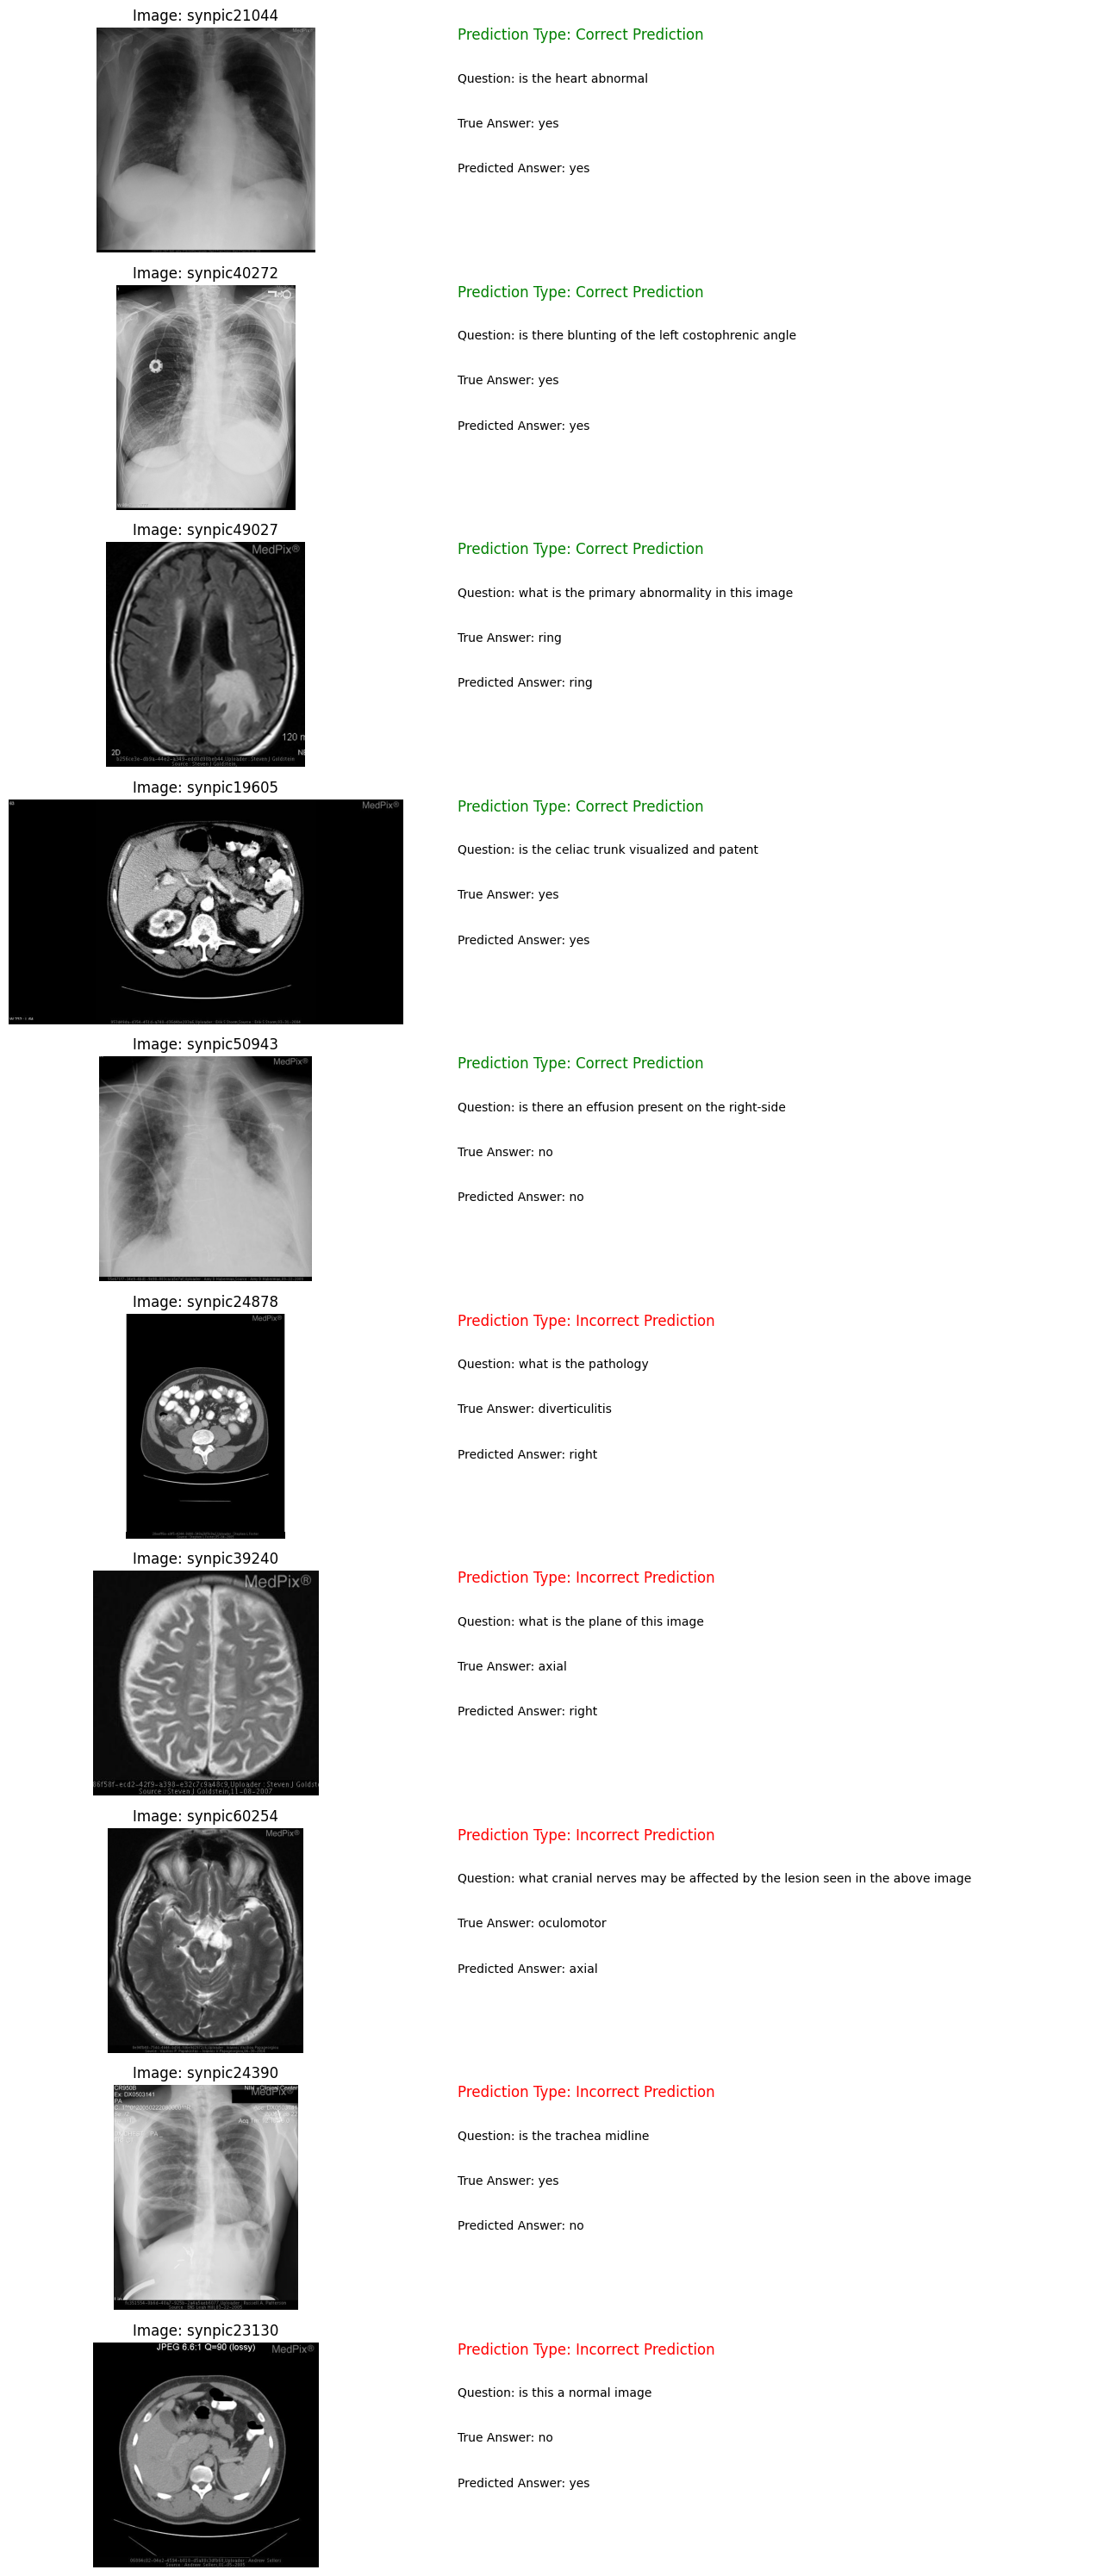

Model prediction examples displayed successfully.


In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# 1. Identify correct and incorrect prediction indices
correct_indices = []
incorrect_indices = []

for i in range(len(all_true_answers)):
    if all_true_answers[i] == all_predicted_answers[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

# 2. Randomly select 5 correct and 5 incorrect examples
num_examples_to_display = 5

# Ensure there are enough samples to pick from
selected_correct_indices = random.sample(correct_indices, min(num_examples_to_display, len(correct_indices)))
selected_incorrect_indices = random.sample(incorrect_indices, min(num_examples_to_display, len(incorrect_indices)))

print(f"Selected {len(selected_correct_indices)} correct predictions and {len(selected_incorrect_indices)} incorrect predictions for display.")

# Combine and process for display
examples_to_display = []

for idx in selected_correct_indices:
    row = test_df.iloc[idx]
    img_id = row['img_id']
    question = row['question']
    true_answer_num = all_true_answers[idx]
    predicted_answer_num = all_predicted_answers[idx]

    true_answer_word = idx_to_word.get(true_answer_num, '<UNKNOWN>')
    predicted_answer_word = idx_to_word.get(predicted_answer_num, '<UNKNOWN>')

    examples_to_display.append({
        'img_id': img_id,
        'question': question,
        'true_answer': true_answer_word,
        'predicted_answer': predicted_answer_word,
        'type': 'Correct Prediction'
    })

for idx in selected_incorrect_indices:
    row = test_df.iloc[idx]
    img_id = row['img_id']
    question = row['question']
    true_answer_num = all_true_answers[idx]
    predicted_answer_num = all_predicted_answers[idx]

    true_answer_word = idx_to_word.get(true_answer_num, '<UNKNOWN>')
    predicted_answer_word = idx_to_word.get(predicted_answer_num, '<UNKNOWN>')

    examples_to_display.append({
        'img_id': img_id,
        'question': question,
        'true_answer': true_answer_word,
        'predicted_answer': predicted_answer_word,
        'type': 'Incorrect Prediction'
    })

# 3 & 4 & 5 & 6. Display examples
image_folder_path = '/content/drive/MyDrive/Med-VQA/VQA_RAD Image Folder'

plt.figure(figsize=(15, len(examples_to_display) * 3))

for i, example in enumerate(examples_to_display):
    img_name = example['img_id'] + '.jpg'
    img_path = os.path.join(image_folder_path, img_name)

    ax = plt.subplot(len(examples_to_display), 2, 2*i + 1) # Image column
    try:
        image = Image.open(img_path)
        ax.imshow(image)
        ax.set_title(f"Image: {example['img_id']}")
        ax.axis('off')
    except FileNotFoundError:
        ax.text(0.5, 0.5, f"Image not found: {img_name}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.axis('off')

    ax_text = plt.subplot(len(examples_to_display), 2, 2*i + 2) # Text column
    ax_text.text(0, 1.0, f"Prediction Type: {example['type']}", fontsize=12, color='green' if example['type'] == 'Correct Prediction' else 'red', ha='left', va='top')
    ax_text.text(0, 0.8, f"Question: {example['question']}", fontsize=10, ha='left', va='top', wrap=True)
    ax_text.text(0, 0.6, f"True Answer: {example['true_answer']}", fontsize=10, ha='left', va='top')
    ax_text.text(0, 0.4, f"Predicted Answer: {example['predicted_answer']}", fontsize=10, ha='left', va='top')
    ax_text.axis('off')

plt.tight_layout()
plt.show()

print("Model prediction examples displayed successfully.")